# Tesla Stock Price Prediction 

# 1. Import All Required Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping


# 2. Load Dataset

In [5]:
df = pd.read_csv("TSLA.csv")
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


# 3. Convert Date & Set Index

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# 4. Handle Missing Values

In [10]:
df.isna().sum()


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# 5. Select Target Feature

In [12]:
data = df[['Close']]


# 6. Exploratory Data Analysis

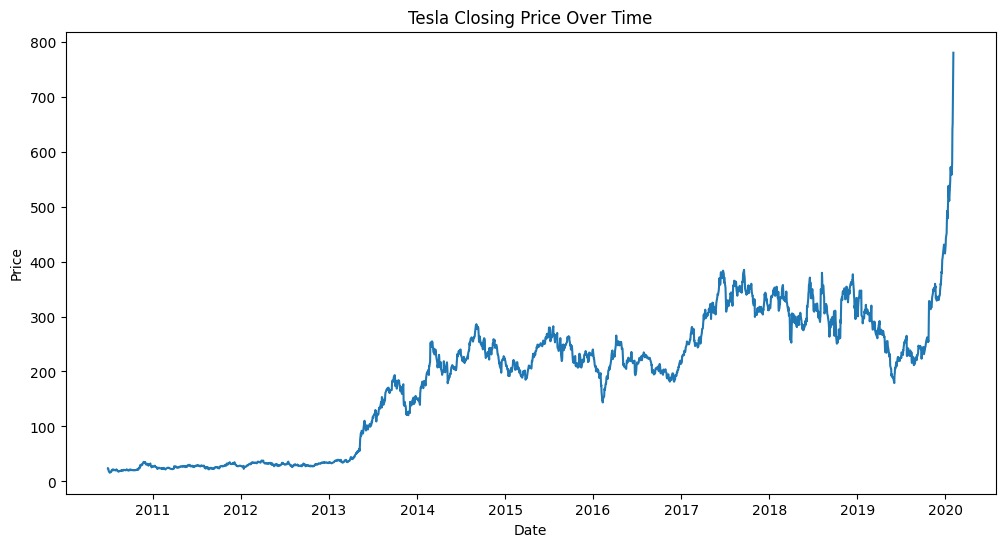

In [14]:
# Closing Price Trend
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title("Tesla Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


C:\Users\VIVOBBOK 16\AppData\Local\Temp\ipykernel_15264\3631777066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA20'] = data['Close'].rolling(20).mean()
C:\Users\VIVOBBOK 16\AppData\Local\Temp\ipykernel_15264\3631777066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA50'] = data['Close'].rolling(50).mean()


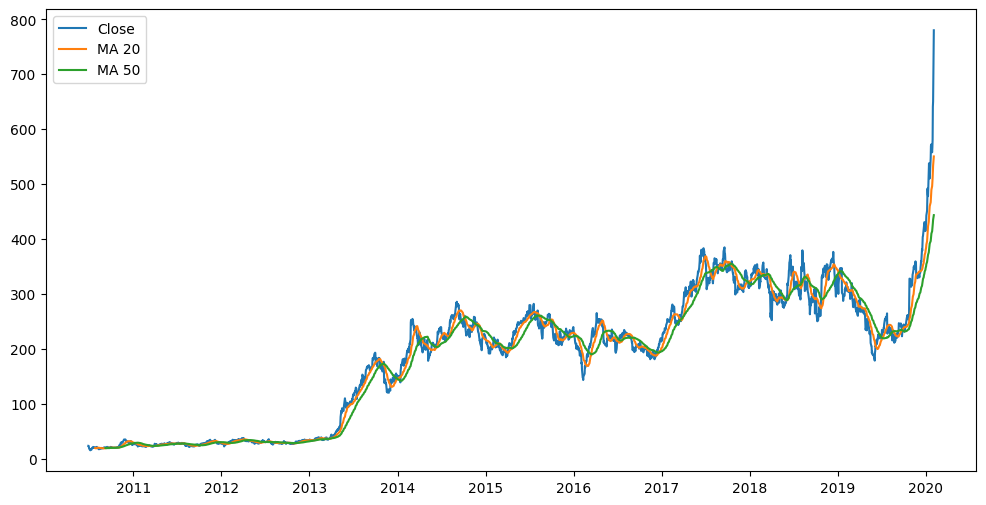

In [15]:
# Moving Averages 
data['MA20'] = data['Close'].rolling(20).mean()
data['MA50'] = data['Close'].rolling(50).mean()

plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close')
plt.plot(data['MA20'], label='MA 20')
plt.plot(data['MA50'], label='MA 50')
plt.legend()
plt.show()


# 7. Scale the Data

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[['Close']])


# 8. Create Time-Series Sequences

In [17]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [19]:
window_size = 30   
X, y = create_sequences(scaled_data, window_size)


# 9. Train-Test Split (80-20)

In [20]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [21]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 10. Build SimpleRNN Model

In [22]:
rnn_model = Sequential([
    SimpleRNN(50, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse')


C:\Users\VIVOBBOK 16\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
rnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5)]
)


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0081 - val_loss: 0.0011
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 6.1269e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7186e-04 - val_loss: 7.9914e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3557e-04 - val_loss: 6.9870e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9099e-04 - val_loss: 6.0296e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0473e-04 - val_loss: 4.6224e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4035e-04 - val_loss: 4.0949e-04
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6713e-04 - val_loss: 0.0011
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1321e-04 - val_loss: 4.4649e-04
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0558e-04 - val_loss: 3.8120e-04
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5004e-04 - val_loss: 8.1203e-04
E

# 11. Build LSTM Model

In [25]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')


In [26]:
lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5)]
)


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.2895e-04 - val_loss: 5.4197e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.4260e-04 - val_loss: 5.7562e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.8545e-04 - val_loss: 4.5892e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.7999e-04 - val_loss: 5.0220e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.2986e-04 - val_loss: 5.0666e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.0882e-04 - val_loss: 4.5113e-04
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.8044e-04 - val_loss: 9.7567e-04
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.6320e-04 - val_loss: 0.0012
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.1931e-04 - val_loss: 3.8937e-04
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.6299e-04 - val_loss

# 12. Make Predictions

In [27]:
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [28]:
rnn_pred = scaler.inverse_transform(rnn_pred)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))


# 13. Evaluate Models

In [29]:
rnn_mse = mean_squared_error(y_test_actual, rnn_pred)
lstm_mse = mean_squared_error(y_test_actual, lstm_pred)

print("SimpleRNN MSE:", rnn_mse)
print("LSTM MSE:", lstm_mse)


SimpleRNN MSE: 484.7790090901536
LSTM MSE: 533.674932696374


# 14. Plot Actual vs Predicted

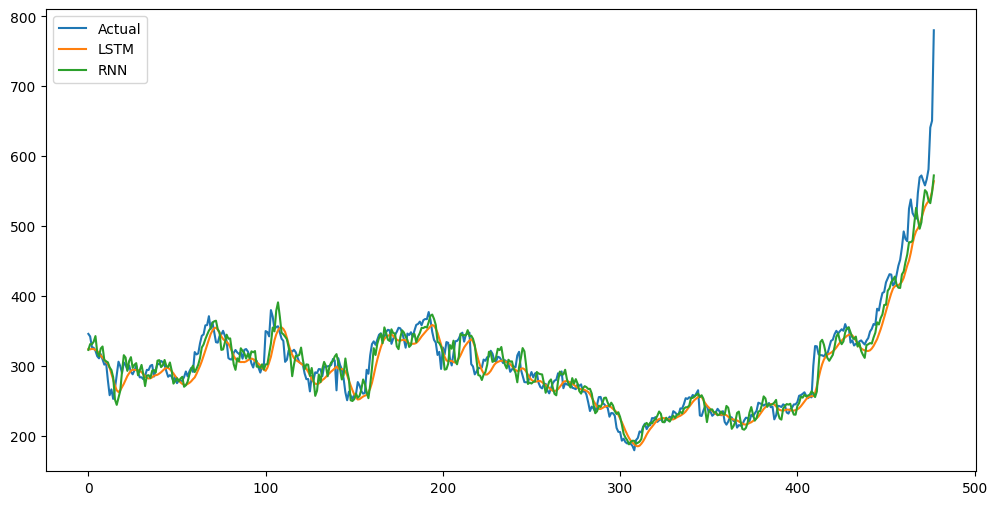

In [30]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual')
plt.plot(lstm_pred, label='LSTM')
plt.plot(rnn_pred, label='RNN')
plt.legend()
plt.show()


# 15. Save Models

In [32]:
rnn_model.save("models/rnn_model.h5")
lstm_model.save("models/lstm_model.h5")
